# **Librerías Necesarias para el proyecto**


---



In [ ]:
# Instalación de paquetes necesarios
# Librería AMPL para DEA
!pip install -q amplpy pandas

# Librería Pymoo para Metaheurístico
!pip install -U -q pymoo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.5 MB/s eta 0:00:00


In [ ]:
# Liberrías para manipulación de datos
import numpy as np
import pandas as pd
import math

# Librería para la varianza retenida
from numpy.linalg import inv

# Librerías para la gestión e interacción con los datos
import io
import re
import sys
import requests
from io import BytesIO
from contextlib import redirect_stdout, redirect_stderr

# Librería para uso de AMPL para Data Envelopment Analisys (DEA)
from amplpy import AMPL, tools

# Librería para evaluar el tiempo de ejecución de los modelos
from time import time

# Librerías de Pymoo para el Metahurístico (Algorítmo Genético GA)
from pymoo.optimize import minimize
from pymoo.problems import get_problem
from pymoo.core.mutation import Mutation
from pymoo.core.sampling import Sampling
from pymoo.core.crossover import Crossover
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.algorithms.moo.age import AGEMOEA
from pymoo.algorithms.moo.sms import SMSEMOA
from pymoo.algorithms.moo.kgb import KGB #=========================== Nuevo en Pymoo ====================
from pymoo.algorithms.moo.dnsga2 import DNSGA2 #=========================== Nuevo en Evaluación ====================
from pymoo.algorithms.moo.age2 import AGEMOEA2 #=========================== Nuevo en Evaluación ====================
from pymoo.util.ref_dirs import get_reference_directions # Para las ref_dirs de NSGA-III
from pymoo.core.problem import Problem, ElementwiseProblem

# Indicadores de desempeño de pymoo
from pymoo.indicators.kktpm import KKTPM
from pymoo.indicators.hv import HV

# Librerías de Pymoo para personalizar los datos en la salida
from pymoo.util.display.column import Column
from pymoo.util.display.output import Output

# Librería para función de Varianza Retenida
from scipy.linalg import inv

# Librerías para Graficar
import matplotlib.pyplot as plt
from pymoo.visualization.pcp import PCP



---


# **Obtención de los datos**

In [ ]:
# URL directa al archivo Excel en Google Drive

#url = 'https://drive.google.com/uc?export=download&id=1ZCS0mr0AaIPP5cL07Ps6pdCcfnz16Xkb'   # Ejemplo Adler

url = 'https://drive.google.com/uc?export=download&id=1_MpRetRTLVSZAxz6V2XlHulELDIJu3Sn'   # Ejemplo EPS Colombia
#url = 'https://drive.google.com/uc?export=download&id=1EPGkqiDol2zVYd5dVLYPMUsbPQg_QA1_'   # Ejemplo Crude Oil 2009 (Se calcula con la Tecnical Efficiency)
#url = 'https://drive.google.com/uc?export=download&id=1tvP0MT9WZUGUT_ONlr8kDleL9UQOLLZ6'   # Ejemplo Calidad de vida (Paper Course Dim. in DEA)

# Descargar el archivo desde la URL utilizando la biblioteca requests
response = requests.get(url)

# Verificar si la descarga fue exitosa comprobando el código de estado HTTP
if response.status_code == 200:
    # Si la descarga fue exitosa, el contenido del archivo se almacena en la variable 'content'
    content = response.content

    # Obtener el nombre del archivo desde los encabezados de la respuesta HTTP (si está presente)
    disposition = response.headers.get('Content-Disposition')

    # Verificar si el encabezado 'Content-Disposition' contiene información sobre el nombre del archivo
    if disposition:
        # Si se encuentra un encabezado con el nombre del archivo, usar una expresión regular para extraerlo
        filename = re.findall('filename="(.+)"', disposition)

        # Si se encuentra un nombre de archivo válido, se usa; de lo contrario, se establece un nombre por defecto
        if filename:
            output_path = filename[0]
        else:
            output_path = 'archivo_descargado.xlsx'  # Nombre por defecto si no se encuentra el nombre del archivo
    else:
        output_path = 'archivo_descargado.xlsx'  # Nombre por defecto si no hay encabezado 'Content-Disposition'

    # Leer las hojas de cálculo directamente desde el contenido descargado usando BytesIO
    # Hoja 0 (primer hoja) corresponde a 'Entradas', y la hoja 1 (segunda hoja) corresponde a 'Salidas'
    Entradas = pd.read_excel(BytesIO(content), sheet_name=0, header=0, index_col=0)  # Leer la hoja de Entradas
    Salidas = pd.read_excel(BytesIO(content), sheet_name=1, header=0, index_col=0)   # Leer la hoja de Salidas

    # Imprimir el nombre del archivo descargado o asignado
    print(f"Archivo Obtenido: {output_path}")
else:
    # Si la descarga falla, se imprime un mensaje de error con el código de estado HTTP
    print(f"Error al descargar el archivo. Código de estado: {response.status_code}")


Archivo Obtenido: 02. EjemploEPSColombia.xlsx


# **Funciones para el Proyecto**

## **DEA**

In [ ]:
def analyze_dea(Entradas, Salidas, tipo_modelo):
    """
    Analiza las DMUs usando el modelo DEA especificado.

    Parameters:
    - Entradas: DataFrame de entradas para cada DMU.
    - Salidas: DataFrame de salidas para cada DMU.
    - tipo_modelo: String que indica el tipo de modelo DEA a implementar ('ccr-i', 'ccr-o', 'env-i', 'env-o', 'bcc-i', 'bcc-o').

    Returns:
    - DataFrame con las eficiencias calculadas para cada DMU.
    - DataFrames con los pesos de las entradas y salidas (o lambdas para modelos env/bcc).
    """
#=====================================================================================================#
    # Almacenar resultados de eficiencia y pesos
    resultados_eficiencia_total = []
    resultados_pesos_entradas_total = []
    resultados_pesos_salidas_total = []
    resultados_lambdas_total = []
#=====================================================================================================#
    # Configuración inicial de AMPL
    f = io.StringIO()
    with redirect_stdout(f), redirect_stderr(f):
        ampl = tools.ampl_notebook(
            modules=["highs"],  # Los optimizadores que vamos a usar
            license_uuid="default"  # licencia para usar
        )

    # Configuración del modelo DEA según el tipo
    ampl_code = get_ampl_code(tipo_modelo)
    ampl.eval(ampl_code)

    # Leer datos de entradas y salidas
    dfEntradas_DEA = Entradas
    dfSalidas_DEA = Salidas
#=====================================================================================================#
    # Notación Conjuntos
    ListaDMUs = list(dfSalidas_DEA.index.map(str))
    ampl.set["DMU"] = ListaDMUs

    ListaEntradas = list(dfEntradas_DEA.columns.map(str))
    ampl.set["Entradas"] = ListaEntradas

    ListaSalidas = list(dfSalidas_DEA.columns.map(str))
    ampl.set["Salidas"] = ListaSalidas

    ampl.param["x"] = dfEntradas_DEA.unstack()
    ampl.param["y"] = dfSalidas_DEA.unstack()
#=====================================================================================================#
    # Ejecutar el modelo DEA
    ampl_code_execution = '''
        option solver highs;
        for {a in DMU} {
            let o := a;
            solve;
            # Guardamos la eficiencia
            let Eficiencia[a] := Efic;
            %s
        }
    ''' % (get_weight_code(tipo_modelo))
#=====================================================================================================#
    # Suprimir la salida de ampl.eval()
    f = io.StringIO()
    with redirect_stdout(f), redirect_stderr(f):
        ampl.eval(ampl_code_execution)

    # Guardar resultados en dataframes
    dfEff = ampl.get_data("Eficiencia").to_pandas().reset_index()

    if tipo_modelo in ['ccr-i', 'ccr-o']:
        dfPesosEntradas = ampl.get_data("pesosEntradas").to_pandas().reset_index()
        dfPesosSalidas = ampl.get_data("pesosSalidas").to_pandas().reset_index()
        resultados_pesos_entradas_total.append(dfPesosEntradas)
        resultados_pesos_salidas_total.append(dfPesosSalidas)
    else:
        dfLambdas = ampl.get_data("valoreslambdas").to_pandas().reset_index()
        resultados_lambdas_total.append(dfLambdas)

    resultados_eficiencia_total.append(dfEff)

    # Concatenar todos los resultados en DataFrames
    dfEffTotal = pd.concat(resultados_eficiencia_total).reset_index(drop=True)
    dfEffTotal.set_index('index', inplace=True)

    if tipo_modelo in ['ccr-i', 'ccr-o']:
        dfPesosEntradasTotal = pd.concat(resultados_pesos_entradas_total).reset_index(drop=True)
        dfPesosSalidasTotal = pd.concat(resultados_pesos_salidas_total).reset_index(drop=True)
        return dfEffTotal, dfPesosEntradasTotal, dfPesosSalidasTotal
    else:
        dfLambdasTotal = pd.concat(resultados_lambdas_total).reset_index(drop=True)
        return dfEffTotal, dfLambdasTotal

#=====================================================================================================#
def get_ampl_code(tipo_modelo):
    """
    Devuelve el código AMPL dependiendo del tipo de modelo DEA.
    """
    if tipo_modelo == 'ccr-i':
        return '''
            reset;

            # Conjuntos
            set DMU;
            set Entradas;
            set Salidas;

            # Parámetros
            param x{Entradas, DMU} >= 0;
            param y{Salidas, DMU} >= 0;

            # Variables
            var v{i in Entradas} >= 0;
            var u{r in Salidas} >= 0;

            # DMU a la que vamos a evaluar
            param o symbolic;

            # Estructuras de datos para guardar los resultados
            param Eficiencia{DMU} >= 0;
            param pesosEntradas{DMU, Entradas} >= 0;
            param pesosSalidas{DMU, Salidas} >= 0;

            # Función objetivo
            maximize Efic: sum{r in Salidas} u[r] * y[r, o];

            # Restricciones
            subject to Normalizacion:
                sum{i in Entradas} v[i] * x[i, o] = 1;

            subject to Hasta100{j in DMU}:
                sum{r in Salidas} u[r] * y[r, j] <= sum{i in Entradas} v[i] * x[i, j];
        '''
#=====================================================================================================#
    elif tipo_modelo == 'ccr-o':
        return '''
            reset;

            # Conjuntos
            set DMU;
            set Entradas;
            set Salidas;

            # Parámetros
            param x{Entradas, DMU} >= 0;
            param y{Salidas, DMU} >= 0;

            # Variables
            var v{i in Entradas} >= 0;
            var u{r in Salidas} >= 0;

            # DMU a la que vamos a evaluar
            param o symbolic;

            # Estructuras de datos para guardar los resultados
            param Eficiencia{DMU} >= 0;
            param pesosEntradas{DMU, Entradas} >= 0;
            param pesosSalidas{DMU, Salidas} >= 0;

            # Función objetivo
            minimize Efic: sum{i in Entradas} v[i] * x[i, o];

            # Restricciones
            subject to Normalizacion:
                sum{r in Salidas} u[r] * y[r, o] = 1;

            subject to Hasta100{j in DMU}:
                sum{r in Salidas} u[r] * y[r, j] <= sum{i in Entradas} v[i] * x[i, j];
        '''
#=====================================================================================================#
    elif tipo_modelo == 'env-i':
        return '''
            reset;

            # Conjuntos
            set DMU;
            set Entradas;
            set Salidas;

            # Parámetros
            param x{Entradas, DMU} >= 0;
            param y{Salidas, DMU} >= 0;

            # Variables
            var lambd{j in DMU} >= 0;
            var theta;

            # DMU a la que vamos a evaluar
            param o symbolic;

            # Estructuras de datos para guardar los resultados
            param Eficiencia{DMU} >= 0;
            param valoreslambdas{DMU, DMU};

            # Función objetivo
            minimize Efic: theta;

            # Restricciones
            subject to ContraerEntradas{i in Entradas}:
                sum{j in DMU} lambd[j] * x[i, j] <= theta * x[i, o];

            subject to GarantizarSalidas{r in Salidas}:
                sum{j in DMU} lambd[j] * y[r, j] >= y[r, o];

        '''
#=====================================================================================================#
    elif tipo_modelo == 'env-o':
        return '''
            reset;

            # Conjuntos
            set DMU;
            set Entradas;
            set Salidas;

            # Parámetros
            param x{Entradas, DMU} >= 0;
            param y{Salidas, DMU} >= 0;

            # Variables
            var lambd{j in DMU} >= 0;
            var eta;

            # DMU a la que vamos a evaluar
            param o symbolic;

            # Estructuras de datos para guardar los resultados
            param Eficiencia{DMU} >= 0;
            param valoreslambdas{DMU, DMU};

            # Función objetivo
            maximize Efic: eta;

            # Restricciones
            subject to ContraerEntradas{i in Entradas}:
                sum{j in DMU} lambd[j] * x[i, j] <= x[i, o];

            subject to GarantizarSalidas{r in Salidas}:
                sum{j in DMU} lambd[j] * y[r, j] >= eta * y[r, o];
        '''
#=====================================================================================================#
    elif tipo_modelo == 'bcc-i':
        return '''
            reset;

            # Conjuntos
            set DMU;
            set Entradas;
            set Salidas;

            # Parámetros
            param x{Entradas, DMU} >= 0;
            param y{Salidas, DMU} >= 0;

            # Variables
            var lambd{j in DMU} >= 0;
            var theta;

            # DMU a la que vamos a evaluar
            param o symbolic;

            # Estructuras de datos para guardar los resultados
            param Eficiencia{DMU} >= 0;
            param valoreslambdas{DMU, DMU};

            # Función objetivo
            minimize Efic: theta;

            # Restricciones
            subject to ContraerEntradas{i in Entradas}:
                sum{j in DMU} lambd[j] * x[i, j] <= theta * x[i, o];

            subject to GarantizarSalidas{r in Salidas}:
                sum{j in DMU} lambd[j] * y[r, j] >= y[r, o];

            subject to SumaLambdas:
                sum{j in DMU} lambd[j] = 1;

        '''
#=====================================================================================================#
    elif tipo_modelo == 'bcc-o':
            return '''
            reset;

            # Conjuntos
            set DMU;
            set Entradas;
            set Salidas;

            # Parámetros
            param x{Entradas, DMU} >= 0;
            param y{Salidas, DMU} >= 0;

            # Variables
            var lambd{j in DMU} >= 0;
            var eta;

            # DMU a la que vamos a evaluar
            param o symbolic;

            # Estructuras de datos para guardar los resultados
            param Eficiencia{DMU} >= 0;
            param valoreslambdas{DMU, DMU};

            # Función objetivo
            maximize Efic: eta;

            # Restricciones
            subject to ContraerEntradas{i in Entradas}:
                sum{j in DMU} lambd[j] * x[i, j] <= x[i, o];

            subject to GarantizarSalidas{r in Salidas}:
                sum{j in DMU} lambd[j] * y[r, j] >= eta * y[r, o];

            subject to SumaLambdas:
                sum{j in DMU} lambd[j] = 1;
        '''
#=====================================================================================================#
def get_weight_code(tipo_modelo):
    """
    Devuelve el código AMPL para guardar los pesos dependiendo del tipo de modelo DEA.
    """
    if tipo_modelo in ['ccr-i', 'ccr-o']:
        return '''
            # Guardamos los pesos de las entradas
            for {i2 in Entradas} {
            let pesosEntradas[a, i2] := if v[i2] >= 1e-8 then v[i2] else 0; # Restrición para Evitar Valores Negativos
            }
            # Guardamos los pesos de las salidas
            for {i3 in Salidas} {
                let pesosSalidas[a, i3] := if u[i3] >= 1e-8 then u[i3] else 0; # Restrición para Evitar Valores Negativos
            }
        '''
    elif tipo_modelo in ['env-i', 'env-o', 'bcc-i', 'bcc-o']:
        return '''
            # Guardamos los valores de las lambdas
            for {i2 in DMU} {
                let valoreslambdas[a, i2] := if lambd[i2] >= 1e-8 then lambd[i2] else 0; # Restrición para Evitar Valores Negativos
            }
        '''

## **Métricas**



---


### **Índice Gini**

In [ ]:
def gini_index(vector):
    """
    Calcula el índice de Gini para un vector dado.
    Si la suma del vector es cero, retorna 0.0.
    """
    vector = np.array(vector)

    # Verificar si el vector está vacío o la suma es cero
    total_sum = np.sum(vector)
    if total_sum == 0:
        return 0.0

    # Ordenar el vector
    vector_sorted = np.sort(vector.flatten())

    # Calcular las proporciones acumulativas
    cum_vector = np.cumsum(vector_sorted) / total_sum
    n = len(vector_sorted)
    cum_aux = (np.arange(1, n+1) / n)

    # Cálculo del índice de Gini
    gini_s = (np.sum(cum_aux - cum_vector)) / np.sum(cum_aux)

    return round(gini_s, 7)



---


### **Varianza Retenida / Covarianza Parcial**

In [ ]:
def var_ret(data, var_include):
    # Verifica que data es un DataFrame de pandas
    if not isinstance(data, pd.DataFrame):
        raise ValueError("El argumento 'data' debe ser un DataFrame de pandas.")

    # Verifica que los nombres de las variables a incluir son válidos
    if not set(var_include).issubset(data.columns):
        raise ValueError("Los nombres de las variables a incluir deben ser columnas válidas en el DataFrame.")

    # Verifica que var_include no esté vacío
    if len(var_include) == 0:
        raise ValueError("El argumento 'var_include' no puede estar vacío.")

    # Convierte el DataFrame a un array de NumPy
    x = data.to_numpy()

    vt = x.shape[1]  # Número total de variables
    p_include = data.columns.get_indexer(var_include)  # Índices de las variables a incluir
    p_exclude = np.setdiff1d(np.arange(vt), p_include)  # Variables a excluir

    # Reordena las variables solo cuando sea necesario
    x_reorder = np.hstack((x[:, p_exclude], x[:, p_include]))

    # Estandariza las variables
    mean_x = np.mean(x_reorder, axis=0)
    std_x = np.std(x_reorder, axis=0)
    x_standardized = (x_reorder - mean_x) / std_x

    # Matriz de covarianza (ya estandarizado, por lo que es lo mismo que la correlación)
    varcov = np.corrcoef(x_standardized, rowvar=False)

    le = len(p_exclude)
    # Submatrices de la matriz de Varianza-Covarianza
    v11 = varcov[:le, :le]
    v12 = varcov[:le, le:]
    v21 = varcov[le:, :le]
    v22 = varcov[le:, le:]

    # Usar descomposición de Cholesky si v22 es simétrica y positiva definida
    try:
        v22_reg = v22 + np.eye(v22.shape[0]) * 1e-6  # Añade un pequeño valor a la diagonal para regularizar
        v22_inv = inv(v22_reg)
    except np.linalg.LinAlgError:
        raise ValueError("La matriz v22 no es invertible, revisar los datos.")

    # Cálculo de la varianza explicada
    vexp = vt - np.sum(np.diag(v11 - np.dot(np.dot(v12, v22_inv), v21)))
    var_exp = vexp / vt

    return var_exp

## **Función para imprimir los mejores candidatos/resultados del GA**

### Positivos

In [ ]:
def process_and_store_results_auto_(res_X, res_F, problema):
    """
    Procesa los resultados de NSGA3 de Pymoo y los almacena en un DataFrame.
    Se adapta automáticamente a las métricas proporcionadas por el problema de Pymoo.

    Parameters:
    - res_X: np.ndarray, matriz de índices y subsets.
    - res_F: np.ndarray, matriz de datos de función objetivo.
    - problema: objeto, problema de Pymoo que contiene los nombres de las métricas.

    Returns:
    - dfres_F: pd.DataFrame, DataFrame con los resultados procesados.
    """

    # Obtener los nombres de las métricas automáticamente del problema
    try:
        metricas = problema.nombres_metricas
    except AttributeError:
        raise AttributeError("El problema no tiene el atributo 'nombres_metricas'. Asegúrate de que esté definido.")

    # Verificar que el número de métricas coincida con las columnas de res_F
    if len(metricas) != res_F.shape[1]:
        raise ValueError("El número de métricas no coincide con el número de columnas en res_F.")

    # Desempaquetar los arrays de la tupla
    gen, subset = np.where(res_X)

    # Obtener el número de filas en res_F
    num_rows_res_F = res_F.shape[0]

    # Crear un DataFrame con las generaciones y los subsets
    dfsubsets = pd.DataFrame({
        'gen': range(num_rows_res_F),
        'subsets': [subset[gen == i] for i in range(num_rows_res_F)]
    })

    # Crear el DataFrame con las métricas proporcionadas
    dfres_F = pd.DataFrame(res_F, columns=metricas)

    # Agregar la columna 'Modelos'
    dfres_F['Modelos'] = [f"Modelo {i+1}" for i in range(len(dfres_F))]

    # Agregar la columna de subsets elegidos
    dfres_F['Subset Elegido'] = dfsubsets['subsets'].values

    # Aplicar transformación a las columnas que no sean 'Modelos' ni 'Subset Elegido'
    cols_to_transform = [col for col in dfres_F.columns if col not in ['Modelos', 'Subset Elegido']]
    dfres_F[cols_to_transform] = np.where(dfres_F[cols_to_transform] < 0,
                                            -dfres_F[cols_to_transform],
                                            dfres_F[cols_to_transform]
                                          )

    # Establecer la columna 'Modelos' como el índice
    dfres_F = dfres_F.set_index('Modelos')

    # Devolver el DataFrame con los resultados
    return dfres_F

### Negativos

In [ ]:
def process_and_store_results_auto_neg(res_X, res_F, problema):
    """
    Procesa los resultados de NSGA3 de Pymoo y los almacena en un DataFrame.
    Se adapta automáticamente a las métricas proporcionadas por el problema de Pymoo.

    Parameters:
    - res_X: np.ndarray, matriz de índices y subsets.
    - res_F: np.ndarray, matriz de datos de función objetivo.
    - problema: objeto, problema de Pymoo que contiene los nombres de las métricas.

    Returns:
    - dfres_F: pd.DataFrame, DataFrame con los resultados procesados.
    """

    # Obtener los nombres de las métricas automáticamente del problema
    try:
        metricas = problema.nombres_metricas
    except AttributeError:
        raise AttributeError("El problema no tiene el atributo 'nombres_metricas'. Asegúrate de que esté definido.")

    # Verificar que el número de métricas coincida con las columnas de res_F
    if len(metricas) != res_F.shape[1]:
        raise ValueError("El número de métricas no coincide con el número de columnas en res_F.")

    # Desempaquetar los arrays de la tupla
    gen, subset = np.where(res_X)

    # Obtener el número de filas en res_F
    num_rows_res_F = res_F.shape[0]

    # Crear un DataFrame con las generaciones y los subsets
    dfsubsets = pd.DataFrame({
        'gen': range(num_rows_res_F),
        'subsets': [subset[gen == i] for i in range(num_rows_res_F)]
    })

    # Crear el DataFrame con las métricas proporcionadas
    dfres_F = pd.DataFrame(res_F, columns=metricas)

    # Agregar la columna 'Modelos'
    dfres_F['Modelos'] = [f"Modelo {i+1}" for i in range(len(dfres_F))]

    # Agregar la columna de subsets elegidos
    dfres_F['Subset Elegido'] = dfsubsets['subsets'].values

    # No aplicar transformación a los valores

    # Establecer la columna 'Modelos' como el índice
    dfres_F = dfres_F.set_index('Modelos')

    # Devolver el DataFrame con los resultados
    return dfres_F

## **Función para automatizar el número de objetivos**

In [ ]:
def determinar_n_obj(tipo_modelo, tipo_resultado):
    if tipo_resultado in ['ccr-i', 'ccr-o']:
        if tipo_modelo == 'modelo_global':
            return 3
        elif tipo_modelo == 'modelo_desagregado':
            return 5
    else:
        if tipo_modelo == 'modelo_global':
            return 3
        elif tipo_modelo == 'modelo_desagregado':
            return 5
    return None  # En caso de que no coincida con ninguna condición

---

## **Función para Implementación de Feature Selection con Algoritmos Genéticos (Multi-Objective Optimization)**

In [ ]:
# Definición de la clase de muestreo personalizada
class MySampling(Sampling):
    def _do(self, problem, n_samples, **kwargs):
        # Número de variables en el problema
        n_vars = problem.n_var

        # Genera una matriz de muestras aleatorias (0 o 1) con n_samples filas y n_vars columnas
        samples = np.random.randint(2, size=(n_samples, n_vars))

        # Asegurarse de que al menos una entrada y una salida estén seleccionadas en cada muestra
        for i in range(n_samples):
            # Si la suma de las entradas o de las salidas es 0, regenerar la muestra
            while np.sum(samples[i, :problem.n_entradas]) == 0 or np.sum(samples[i, problem.n_entradas:]) == 0:
                # Regenera la muestra si no se ha seleccionado al menos una entrada y una salida
                samples[i] = np.random.randint(2, size=n_vars)

        # Devuelve las muestras válidas
        return samples

# Definición de la clase de cruce personalizada
class BinaryCrossover(Crossover):
    def __init__(self):
        # Define que el cruce requiere 2 padres para generar 1 hijo
        super().__init__(2, 1)

    def _do(self, problem, X, **kwargs):
        # X.shape devuelve una matriz (2 padres, n_matings, n_var)
        n_parents, n_matings, n_var = X.shape

        # Inicializa la matriz para almacenar los hijos generados por el cruce
        _X = np.full((self.n_offsprings, n_matings, n_var), False)

        # Recorre cada cruce para combinar padres y generar un hijo
        for k in range(n_matings):
            p1, p2 = X[0, k], X[1, k]  # Selecciona los dos padres
            both_are_true = np.logical_and(p1, p2)  # Detecta donde ambos padres tienen 1
            _X[0, k, both_are_true] = True  # El hijo hereda estas posiciones donde ambos padres tienen 1

            # Calcula el número de variables que quedan por asignar al hijo
            n_remaining = n_var - np.sum(both_are_true)
            # Selecciona donde los padres difieren (uno tiene 1 y el otro 0)
            I = np.where(np.logical_xor(p1, p2))[0]
            if len(I) > 0:
                # Elige aleatoriamente algunas de estas posiciones para asignarlas al hijo
                S = I[np.random.permutation(len(I))][:n_remaining]
                _X[0, k, S] = True  # Asigna esas posiciones seleccionadas al hijo

        # Devuelve los hijos generados
        return _X

# Definición de la clase de mutación personalizada
class MyMutation(Mutation):
    def _do(self, problem, X, **kwargs):
        # Recorre cada individuo (solución) en la población
        for i in range(X.shape[0]):
            # Encuentra las posiciones donde la solución tiene 0 (var. no seleccionadas)
            is_false = np.where(np.logical_not(X[i, :]))[0]
            # Encuentra las posiciones donde la solución tiene 1 (var. seleccionadas)
            is_true = np.where(X[i, :])[0]

            # Cambia un valor de 0 a 1 aleatoriamente, si hay 0s disponibles
            if len(is_false) > 0:
                X[i, np.random.choice(is_false)] = True
            # Cambia un valor de 1 a 0 aleatoriamente, si hay 1s disponibles
            if len(is_true) > 0:
                X[i, np.random.choice(is_true)] = False

        # Devuelve las soluciones mutadas
        return X

# Definición del problema de optimización de selección de subconjuntos
class SubsetProblem(ElementwiseProblem):
    def __init__(self, entradas, salidas, tipo_modelo, tipo_resultado):
        n_entradas = entradas.shape[1]  # Número de columnas en el DataFrame de entradas
        n_salidas = salidas.shape[1]     # Número de columnas en el DataFrame de salidas

        # Determina el número de objetivos y las métricas basadas en el tipo de modelo y resultado
        if tipo_resultado == 'modelo_global':
            if tipo_modelo in ['ccr-i', 'ccr-o']:
                n_obj = 3 #6  # 3 métricas básicas + 3 métricas de pesos para CCR
                self.nombres_metricas = ['% DMUs Ineff',
                                         'Var. Ret. Total',
                                         #'Gini Eff'
                                         'Gini Pond.'
                                         ]
            else:
                n_obj = 3 #5  # 3 métricas básicas + 2 métricas de lambdas
                self.nombres_metricas = ['% DMUs Ineff',
                                         'Var. Ret. Total',
                                         #'Gini Eff'
                                         'Gini Pond.'
                                         ]

        elif tipo_resultado == 'modelo_desagregado':
            if tipo_modelo in ['ccr-i', 'ccr-o']:
                n_obj = 5 #9  # 5 Métricas básicas + 4 Métricas para CCR
                self.nombres_metricas = ['% DMUs Ineff',
                                         'Var.Ret.In',
                                         'Var.Ret.Out',
                                         'Var.Ret.Total',
                                         #'Gini Eff'
                                         #'Gini Ineff'
                                         'Gini Pond'
                                         ]
            else:
                n_obj = 5 #7  # 5 métricas básicas + 2 métricas de lambdas
                self.nombres_metricas = ['% DMUs Ineff',
                                         'Var.Ret.In',
                                         'Var.Ret.Out',
                                         'Var.Ret.Total',
                                         #'Gini Eff'
                                         #'Gini Ineff'
                                         'Gini Pond'
                                         ]
        else:
            raise ValueError("Tipo de resultado no reconocido. Usa 'modelo_global' o 'modelo_desagregado'.")

        # Inicializa la clase base con el número de variables, objetivos y límites
        super().__init__(n_var = n_entradas + n_salidas, n_obj = n_obj, n_ieq_constr = 0, xl = 0, xu = 1)
        self.entradas = entradas  # Almacena el DataFrame de entradas
        self.salidas = salidas    # Almacena el DataFrame de salidas
        self.n_entradas = n_entradas  # Almacena el número de entradas
        self.n_salidas = n_salidas      # Almacena el número de salidas
        self.tipo_modelo = tipo_modelo    # Almacena el tipo de modelo
        self.tipo_resultado = tipo_resultado  # Almacena el tipo de resultado

    def _evaluate(self, x, out, *args, **kwargs):
        x = np.array(x, dtype=int)
        selected_entradas = x[:self.n_entradas]
        selected_salidas = x[self.n_entradas:]

        if np.sum(selected_entradas) == 0 or np.sum(selected_salidas) == 0:
            out["F"] = [1e6] * len(self.nombres_metricas)
            return

        entradas_seleccionadas = self.entradas.iloc[:, selected_entradas.astype(bool)]
        salidas_seleccionadas = self.salidas.iloc[:, selected_salidas.astype(bool)]

        eff_dea = analyze_dea(entradas_seleccionadas, salidas_seleccionadas, self.tipo_modelo)

        # Calcula el coeficiente de Gini
        gini_eff = gini_index(eff_dea[0])

        # Gini Ineficiencia
        gini_inef = gini_index(1 - eff_dea[0])

        # Gini Ponderado
        gini_pond = (gini_eff + gini_inef)/2

        # Cuenta el número de DMUs eficientes
        dmus_eff = np.count_nonzero(eff_dea[0] >= 0.9999)

        dmus_ineff = np.count_nonzero(eff_dea[0] < 0.9999)

        # Porcentaje DMUs Eficientes
        porcent_dmus = dmus_eff / eff_dea[0].shape[0]
        # Porcentaje DMUs Ineficientes
        porcent_dmus_ineff = dmus_ineff / eff_dea[0].shape[0]

        # Penalización si no hay DMUs eficientes
        if dmus_eff == 0:
            out["F"] = [1e6] * len(self.nombres_metricas)  # Penaliza con un valor alto en todos los objetivos
            return

        # Calcula la varianza retenida en las entradas y salidas seleccionadas
        varianza_ret = var_ret(pd.concat([self.entradas, self.salidas], axis=1),
                               list(entradas_seleccionadas.columns) + list(salidas_seleccionadas.columns))

        # Calcula la varianza retenida en las entradas
        varianza_ret_in = var_ret((self.entradas),
                               list(entradas_seleccionadas.columns))

        # Calcula la varianza retenida en las salidas
        varianza_ret_out = var_ret((self.salidas),
                               list(salidas_seleccionadas.columns))

        if self.tipo_modelo in ['ccr-i', 'ccr-o']:
            # Cálculo de las nuevas métricas para CCR-I y CCR-O
            #entropia_relat_in = calcular_entropia(eff_dea[1].iloc[:, 2])  # Entropía pesos entradas

            #entropia_relat_out = calcular_entropia(eff_dea[2].iloc[:, 2])  # Entropía pesos salidas

            #porcent_pesos_total = ((np.count_nonzero(eff_dea[1].iloc[:, 2] > 0)
                                    #+ np.count_nonzero(eff_dea[2].iloc[:, 2] > 0)) /
                                    #(len(eff_dea[1].iloc[:, 2]) + len(eff_dea[2].iloc[:,2])))  # Proporción pesos totales > 0

            #porcent_pesos_in = np.count_nonzero(eff_dea[1].iloc[:,2] > 0) / len(eff_dea[1].iloc[:,2])  # Proporción pesos entradas > 0

            #porcent_pesos_out = np.count_nonzero(eff_dea[2].iloc[:,2] > 0) / len(eff_dea[2].iloc[:,2])  # Proporción pesos salidas > 0

            if self.tipo_resultado == 'modelo_global':
                out["F"] = [
                            -porcent_dmus_ineff,
                            -varianza_ret,
                            #-gini_eff
                            #-gini_inef
                            -gini_pond
                            ]

            elif self.tipo_resultado == 'modelo_desagregado':
                out["F"] = [
                            -porcent_dmus_ineff,
                            -varianza_ret_in,
                            -varianza_ret_out,
                            -varianza_ret,
                            #-gini_eff
                            #-gini_inef
                            -gini_pond
                            ]


        else:
            # Cálculo de las nuevas métricas para otros modelos (BCC, ENV, etc.)
            #porcent_pesos_lamb = np.count_nonzero(eff_dea[1].iloc[:,2] > 0) / len(eff_dea[1].iloc[:,2])  # Proporción lambdas > 0
            #entropia_relat_lambda = calcular_entropia(eff_dea[1].iloc[:, 2])  # Entropía lambdas

            if self.tipo_resultado == 'modelo_global':

                out["F"] = [
                            -porcent_dmus_ineff,
                            -varianza_ret,
                            #-gini_eff
                            #-gini_inef
                            -gini_pond
                            ]


            elif self.tipo_resultado == 'modelo_desagregado':

                out["F"] = [
                            -porcent_dmus_ineff,
                            -varianza_ret_in,
                            -varianza_ret_out,
                            -varianza_ret,
                            #-gini_eff
                            #-gini_inef
                            -gini_pond
                            ]

#==============================================================================================================

# **Parámetros de inicialización**

In [ ]:

tipo_resultado = 'modelo_desagregado'   # Tipo de resultado acepta 'modelo_global' o 'modelo_desagregado'
tipo_modelo_dea = 'ccr-i'               # Acepta 'ccr-i', 'ccr-o', 'env-i', 'env-o', 'bcc-i' o 'bcc-o'

# Parámetros de NSGA2
generaciones = 10
max_poblacion = 200

# Factor de ajuste para la generación de la población
factor_ajuste = (math.log2(Entradas.shape[1] + 1) + math.log2(Salidas.shape[1] + 1)) / 5

# Calculamos la población ajustada con el factor de ajuste
poblacion = math.ceil(((2**Entradas.shape[1] - 1) * (2**Salidas.shape[1] - 1)) / generaciones * factor_ajuste)
pob_real = math.ceil(((2**Entradas.shape[1] - 1) * (2**Salidas.shape[1] - 1)) / generaciones * factor_ajuste)
# Limitamos la población al valor máximo
poblacion = min(poblacion, max_poblacion)
print(f'La Población Inicial es de {pob_real} individuos y se usarán {poblacion} individuos')

n_obj = determinar_n_obj(tipo_resultado, tipo_modelo_dea)
print(f'El número de objetivos para este caso es de: {n_obj}')

La Población Inicial es de 10 individuos y se usarán 10 individuos
El número de objetivos para este caso es de: 5


# **Ejecución Algoritmos Evolutivos**

## **Ejecutar NSGA-II**

In [ ]:
# Define el algoritmo NSGA2 con operadores personalizados
algorithm_nsga2 = NSGA2(
    pop_size  = poblacion,
    sampling  = MySampling(),
    crossover = BinaryCrossover(),
    mutation  = MyMutation(),
    eliminate_duplicates=True
)

# Define el problema
problem_nsga2 = SubsetProblem(Entradas, Salidas, tipo_modelo_dea, tipo_resultado)

# Define el tiempo inicial de ejecución
t0_nsga2 = time()

# Ejecuta la optimización
res_nsga2 = minimize(
    problem_nsga2,
    algorithm_nsga2,
    ('n_gen', generaciones),
    seed=1,
    verbose=True
)

# Marca el tiempo de finalización
elapsed_time_nsga2 = time() - t0_nsga2

# Calcula minutos y segundos
minutes_nsga2 = int(elapsed_time_nsga2 // 60)
seconds_nsga2 = elapsed_time_nsga2 % 60

# Imprime el tiempo de ejec. en formato "minutos:segundos"
print("\n NSGA-2 finalizado en: %d minutos y %.3f segundos" % (minutes_nsga2, seconds_nsga2))

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       10 |      9 |             - |             -
     2 |       20 |     10 |  0.0886380138 |         nadir
     3 |       30 |     10 |  0.0655375978 |         ideal
     4 |       40 |     10 |  0.0576110166 |             f
     5 |       50 |     10 |  0.0569614873 |             f
     6 |       60 |     10 |  0.0393975314 |             f
     7 |       70 |     10 |  0.0078522660 |         nadir
     8 |       80 |     10 |  0.0191026884 |             f
     9 |       90 |     10 |  0.0267883808 |             f
    10 |      100 |     10 |  0.0521246667 |             f

 NSGA-2 finalizado en: 8 minutos y 59.033 segundos


## **Ejecutar NSGA-III**

In [ ]:
# create the reference directions to be used for the optimization
ref_dirs = get_reference_directions("energy", n_dim = n_obj, n_points = poblacion)

#define el timepo inicial de ejecución
t0 = time()

# Define el algoritmo
algorithm_nsga3 = NSGA3(
                ref_dirs  = ref_dirs,
                pop_size  = poblacion,
                sampling  = MySampling(),
                crossover = BinaryCrossover(),
                mutation  = MyMutation(),
                eliminate_duplicates=True
                )

# Define el problema (asume que `Entradas` y `Salidas` son DataFrames válidos)
problem_nsga3 = SubsetProblem(Entradas, Salidas, tipo_modelo_dea, tipo_resultado)

# Ejecuta la minimización
res_nsga3 = minimize(problem_nsga3,
                    algorithm_nsga3,
                    ('n_gen', generaciones),
                    seed = 1,
                    verbose = True)

# Marca el tiempo de finalización
elapsed_time = time() - t0

# Calcula minutos y segundos
minutes = int(elapsed_time // 60)
seconds = elapsed_time % 60

# Imprime el resultado en formato "minutos:segundos"
print("\n NSGA-3 finalizado en: %d minutos and %.3f segundos" % (minutes, seconds))

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       10 |      4 |             - |             -
     2 |       20 |      5 |  0.2500000000 |         ideal
     3 |       30 |      5 |  0.2182287749 |         nadir
     4 |       40 |      5 |  0.1111111111 |         ideal
     5 |       50 |      6 |  0.1818181818 |         ideal
     6 |       60 |      7 |  0.0257545655 |             f
     7 |       70 |      7 |  0.0355905848 |             f
     8 |       80 |      6 |  5.3900133269 |         nadir
     9 |       90 |      5 |  0.4222519976 |         nadir
    10 |      100 |      5 |  0.000000E+00 |             f

 NSGA-3 finalizado en: 9 minutos and 0.071 segundos


## **Ejecutar AGE-MOEA**

In [ ]:
#define el timepo inicial de ejecución
t0 = time()

# Define el algoritmo
algorithm_agemoea = AGEMOEA(
                pop_size  = poblacion,
                sampling  = MySampling(),
                crossover = BinaryCrossover(),
                mutation  = MyMutation(),
                eliminate_duplicates=True
                )

# Define el problema (asume que `Entradas` y `Salidas` son DataFrames válidos)
problem_agemoea = SubsetProblem(Entradas, Salidas, tipo_modelo_dea, tipo_resultado)

# Ejecuta la minimización
res_agemoea = minimize(problem_agemoea,
                    algorithm_agemoea,
                    ('n_gen', generaciones),
                    seed = 1,
                    verbose = True)

# Marca el tiempo de finalización
elapsed_time = time() - t0

# Calcula minutos y segundos
minutes = int(elapsed_time // 60)
seconds = elapsed_time % 60

# Imprime el resultado en formato "minutos:segundos"
print("\n AGE-MOEA finalizado en: %d minutos and %.3f segundos" % (minutes, seconds))

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       10 |      9 |             - |             -
     2 |       20 |     10 |  0.0655375978 |         ideal
     3 |       30 |     10 |  0.0758086414 |             f
     4 |       40 |     10 |  0.000000E+00 |             f
     5 |       50 |     10 |  0.0458565761 |             f
     6 |       60 |     10 |  0.000000E+00 |             f
     7 |       70 |     10 |  0.0342046851 |             f
     8 |       80 |     10 |  0.000000E+00 |             f
     9 |       90 |     10 |  0.000000E+00 |             f
    10 |      100 |     10 |  0.000000E+00 |             f

 AGE-MOEA finalizado en: 9 minutos and 4.736 segundos


## **Ejecutar SMS-EMOA**

In [ ]:
#define el timepo inicial de ejecución
t0 = time()

# Define el algoritmo
algorithm_smsemoa = SMSEMOA(
                pop_size  = poblacion,
                sampling  = MySampling(),
                crossover = BinaryCrossover(),
                mutation  = MyMutation(),
                eliminate_duplicates=True
                )

# Define el problema (asume que `Entradas` y `Salidas` son DataFrames válidos)
problem_smsemoa = SubsetProblem(Entradas, Salidas, tipo_modelo_dea, tipo_resultado)

# Ejecuta la minimización
res_smsemoa = minimize(problem_smsemoa,
                    algorithm_smsemoa,
                    ('n_gen', generaciones),
                    seed = 1,
                    verbose = True)

# Marca el tiempo de finalización
elapsed_time = time() - t0

# Calcula minutos y segundos
minutes = int(elapsed_time // 60)
seconds = elapsed_time % 60

# Imprime el resultado en formato "minutos:segundos"
print("\n SMS-EMOA finalizado en: %d minutos and %.3f segundos" % (minutes, seconds))

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       10 |      9 |             - |             -
     2 |       20 |     10 |  0.1271044269 |             f
     3 |       30 |     10 |  0.1049083991 |             f
     4 |       40 |     10 |  0.4222519976 |         nadir
     5 |       50 |     10 |  0.0444204576 |             f
     6 |       60 |     10 |  0.0554665335 |             f
     7 |       70 |     10 |  0.0655375978 |         ideal
     8 |       80 |     10 |  0.0372547562 |             f
     9 |       90 |     10 |  0.2067215594 |         nadir
    10 |      100 |     10 |  0.1023996386 |             f

 SMS-EMOA finalizado en: 8 minutos and 45.074 segundos


# **Resultados Algoritmos Evolutivos para Optimización Multiobjetivo (MOO)**

### **Resultados NSGA-II**

In [ ]:
# Llamar a la función para procesar y mostrar los resultados
resul_nsga2 = process_and_store_results_auto_(res_nsga2.X, res_nsga2.F, problem_nsga2)
resul_nsga2

,% DMUs Ineff,Var.Ret.In,Var.Ret.Out,Var.Ret.Total,Gini Pond,Subset Elegido
Modelos,,,,,,
Modelo 1,0.294118,1.000000,0.999620,0.999885,0.429555,"[0, 1, 2, 3, 5, 6]"
Modelo 2,0.941176,0.922547,1.000000,0.965596,0.265180,"[2, 3, 4, 5, 6]"
Modelo 3,0.941176,0.438032,1.000000,0.954280,0.427314,"[3, 4, 5, 6]"
Modelo 4,0.882353,0.505092,1.000000,0.879264,0.317353,"[0, 4, 5, 6]"
Modelo 5,0.529412,1.000000,0.924484,0.993876,0.441180,"[0, 1, 2, 3, 5]"
Modelo 6,0.764706,0.919850,0.956371,0.953312,0.355595,"[0, 3, 6]"
Modelo 7,0.529412,0.892067,1.000000,0.973950,0.382169,"[0, 2, 4, 5, 6]"
Modelo 8,0.705882,0.524924,0.999620,0.994026,0.407016,"[1, 3, 5, 6]"
Modelo 9,0.823529,0.925681,0.956371,0.960316,0.335602,"[0, 1, 6]"


### **Resultados NSGA-III**

In [ ]:
# Llamar a la función para procesar y mostrar los resultados
resul_nsga3 = process_and_store_results_auto_(res_nsga3.X, res_nsga3.F, problem_nsga3) #Energy, poblacion_nsga = 10
resul_nsga3

,% DMUs Ineff,Var.Ret.In,Var.Ret.Out,Var.Ret.Total,Gini Pond,Subset Elegido
Modelos,,,,,,
Modelo 1,0.705882,0.919850,0.999511,0.959073,0.352175,"[0, 3, 4, 5]"
Modelo 2,0.294118,1.000000,0.999620,0.999885,0.429555,"[0, 1, 2, 3, 5, 6]"
Modelo 3,0.941176,0.922547,1.000000,0.965596,0.265180,"[2, 3, 4, 5, 6]"
Modelo 4,0.823529,0.978127,0.924484,0.977231,0.366272,"[0, 2, 3, 5]"
Modelo 5,0.411765,1.000000,0.956371,0.996742,0.425281,"[0, 1, 2, 3, 6]"


### **Resultados AGE-MOEA**

In [ ]:
# Llamar a la función para procesar y mostrar los resultados
resul_agemoea = process_and_store_results_auto_(res_agemoea.X, res_agemoea.F, problem_agemoea) #Energy, poblacion_nsga = 10
resul_agemoea

,% DMUs Ineff,Var.Ret.In,Var.Ret.Out,Var.Ret.Total,Gini Pond,Subset Elegido
Modelos,,,,,,
Modelo 1,0.823529,0.925681,0.985457,0.962617,0.330231,"[0, 1, 4, 6]"
Modelo 2,0.823529,0.925681,0.956371,0.960316,0.335602,"[0, 1, 6]"
Modelo 3,0.882353,0.505092,1.000000,0.879264,0.317353,"[0, 4, 5, 6]"
Modelo 4,0.294118,1.000000,0.999620,0.999885,0.429555,"[0, 1, 2, 3, 5, 6]"
Modelo 5,0.941176,0.487843,0.999620,0.893589,0.263798,"[2, 5, 6]"
Modelo 6,0.529412,1.000000,0.924484,0.993876,0.441180,"[0, 1, 2, 3, 5]"
Modelo 7,0.705882,0.524924,1.000000,0.994614,0.406601,"[1, 3, 4, 5, 6]"
Modelo 8,0.764706,0.927886,0.965892,0.972451,0.354465,"[0, 1, 2, 4]"
Modelo 9,0.823529,0.925469,0.985457,0.967865,0.341205,"[1, 2, 4, 6]"


### **Resultados SMS-EMOA**

In [ ]:
# Llamar a la función para procesar y mostrar los resultados
resul_smsemoa = process_and_store_results_auto_(res_smsemoa.X, res_smsemoa.F, problem_smsemoa) #Energy, poblacion_nsga = 10
resul_smsemoa

,% DMUs Ineff,Var.Ret.In,Var.Ret.Out,Var.Ret.Total,Gini Pond,Subset Elegido
Modelos,,,,,,
Modelo 1,0.294118,1.000000,0.999620,0.999885,0.429555,"[0, 1, 2, 3, 5, 6]"
Modelo 2,0.705882,0.524924,1.000000,0.994614,0.406601,"[1, 3, 4, 5, 6]"
Modelo 3,0.882353,0.892067,0.924484,0.919220,0.344749,"[0, 2, 5]"
Modelo 4,0.529412,1.000000,0.924484,0.993876,0.441180,"[0, 1, 2, 3, 5]"
Modelo 5,0.529412,0.998581,0.999511,0.999519,0.388517,"[0, 1, 3, 4, 5]"
Modelo 6,0.941176,0.922547,1.000000,0.965596,0.265180,"[2, 3, 4, 5, 6]"
Modelo 7,0.352941,0.998609,0.999620,0.999439,0.419910,"[1, 2, 3, 5, 6]"
Modelo 8,0.294118,0.927886,1.000000,0.981645,0.422001,"[0, 1, 2, 4, 5, 6]"
Modelo 9,0.647059,0.998581,0.924484,0.985334,0.425677,"[0, 1, 3, 5]"



---


# **Performance Indicator: Hypervolume**

In [ ]:
import numpy as np
from pymoo.indicators.hv import HV

# Diccionario de resultados y problemas asociados
resultados = {
    "NSGA-II": (res_nsga2.X, res_nsga2.F, problem_nsga2),
    "NSGA-III": (res_nsga3.X, res_nsga3.F, problem_nsga3),
    "AGE-MOEA": (res_agemoea.X, res_agemoea.F, problem_agemoea),
    "SMS-EMOA": (res_smsemoa.X, res_smsemoa.F, problem_smsemoa)
}

# Lista para almacenar los valores de HV
hv_values = []

# Evaluar hipervolumen para cada algoritmo (solo valores negativos)
for nombre, (X, F, problem) in resultados.items():
    # Procesa los resultados negativos
    resul_neg = process_and_store_results_auto_neg(X, F, problem)

    # Generar el array numérico para los valores negativos
    num_arr_neg = resul_neg.select_dtypes(include=[np.number]).to_numpy()

    # Ref point para negativos y cálculo
    ref_point_neg = np.full(num_arr_neg.shape[1], 0)  # Usar 0 como referencia para los valores negativos
    ind_neg = HV(ref_point=ref_point_neg)
    hv_neg_value = ind_neg(num_arr_neg)
    hv_values.append((nombre, hv_neg_value))
    print(f"HV para {nombre}:", hv_neg_value)

# Encontrar el máximo HV y mostrar el algoritmo correspondiente
max_hv = max(hv_values, key=lambda x: x[1])

print("\nEl modelo con MAYOR HV es:", max_hv[0], "con un valor de:", max_hv[1])


HV para NSGA-II: 0.37130848766415037
HV para NSGA-III: 0.3457035580505644
HV para AGE-MOEA: 0.3444147663005561
HV para SMS-EMOA: 0.3743121520756887

El modelo con MAYOR HV es: SMS-EMOA con un valor de: 0.3743121520756887


# **Visualización Gráfica de los Modelos**

## NSGA-II

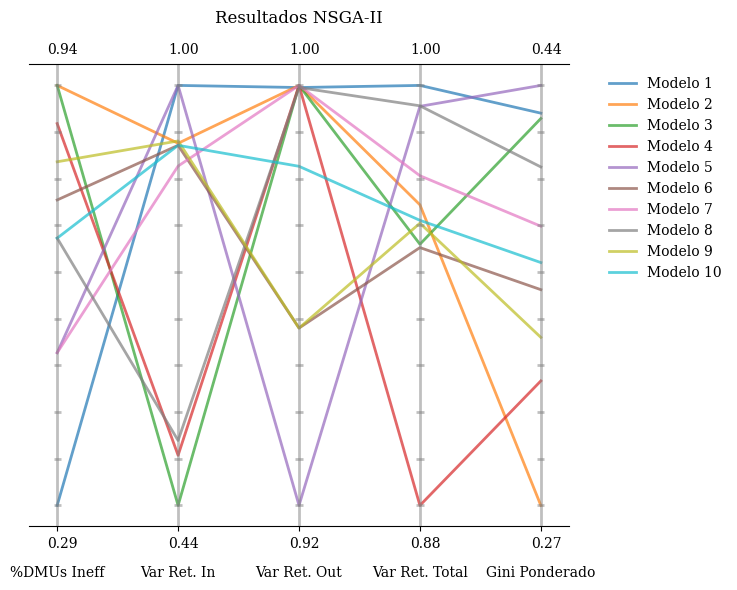

In [ ]:
# @title
import numpy as np
import matplotlib.pyplot as plt
from pymoo.visualization.pcp import PCP

# Definir los labels
labels = ["%DMUs Ineff", "Var Ret. In", "Var Ret. Out", "Var Ret. Total", "Gini Ponderado"]

# Número de dimensiones
num_dim = len(labels)

# Gráfico de coordenadas paralelas
plot = PCP(title=("Resultados NSGA-II", {'pad': 30}),
           n_ticks=10,
           legend=(True, {'loc': "upper left", 'frameon': False}),
           labels=labels)

plot.set_axis_style(color="grey", alpha=0.5)

# Número de soluciones en res_nsga2.F
num_solutions = res_nsga2.F.shape[0]

# Genera un mapa de colores con Matplotlib
colors = plt.cm.tab10(np.linspace(0, 1, num_solutions))  # Usa un colormap con 10 colores distintos

# Añade las soluciones al gráfico con etiquetas "Modelo 1", "Modelo 2", ..., etc.
for i in range(num_solutions):
    label = f"Modelo {i + 1}"  # Etiquetas del tipo "Modelo 1", "Modelo 2", ...

    # Obtener el valor absoluto de res_nsga2.F[i]
    abs_solution = np.abs(res_nsga2.F[i])

    plot.add(abs_solution, linewidth=2, color=colors[i % 10], alpha=0.7, label=label)

# Muestra el gráfico
plot.show()

# Después de mostrar el gráfico, usamos matplotlib para mover la leyenda
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), frameon=False)
plt.subplots_adjust(right=0.8)  # Ajustar para evitar que se corte la leyenda
plt.show()


In [ ]:
# Selección de modelos a destacar (por ejemplo, Modelo 1 y Modelo 2)
modelos_a_destacar = [0, 2]  # Índices de las filas a destacar en res_nsga2.F

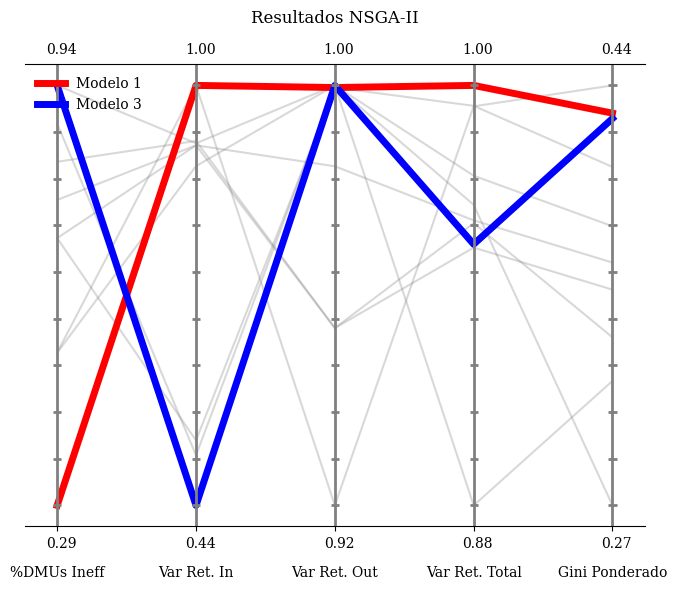

In [ ]:
# @title
# Definir los labels
labels = ["%DMUs Ineff", "Var Ret. In", "Var Ret. Out", "Var Ret. Total", "Gini Ponderado"]

# Número de dimensiones de res_nsga2.F
num_dim = len(labels)  # Asegúrate de que el número de labels coincida con las dimensiones de res_nsga2.F

# Selección de modelos a destacar (por ejemplo, Modelo 1 y Modelo 2)
#modelos_a_destacar = [0, 2]  # Índices de las filas a destacar en res_nsga2.F

# Genera el gráfico de coordenadas paralelas
plot = PCP(title=("Resultados NSGA-II", {'pad': 30}),
           n_ticks=10,
           legend=(True, {'loc': "upper left", 'frameon': False}),
           labels=labels)

plot.set_axis_style(color="grey", alpha=1)

# Añade todas las soluciones (con menor opacidad)
plot.add(np.abs(res_nsga2.F), color="grey", alpha=0.3)

# Colores para los modelos destacados
colores = ["red", "blue"]

# Graficar dinámicamente los modelos seleccionados
for i, modelo in enumerate(modelos_a_destacar):
    plot.add(np.abs(res_nsga2.F[modelo]),
             linewidth=5,
             color=colores[i % len(colores)],  # Asigna colores cíclicamente si hay más modelos
             label=f"Modelo {modelo + 1}")

plot.show()


## NSGA-III

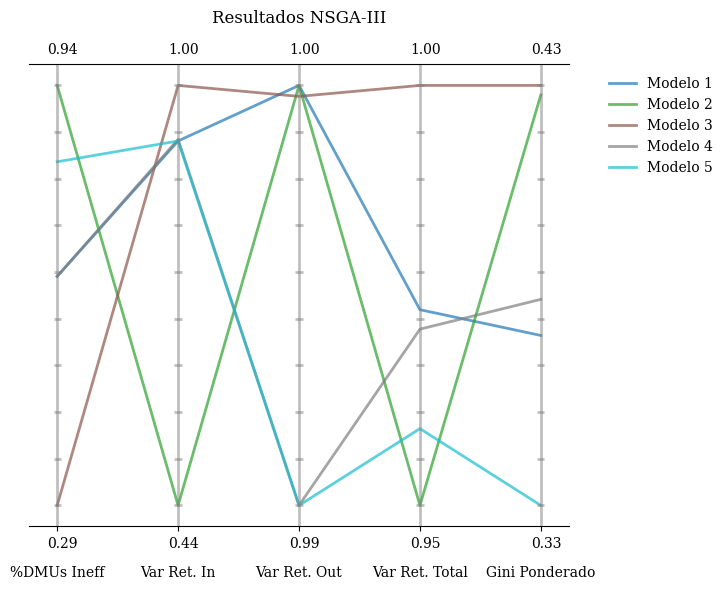

In [ ]:
# @title
import numpy as np
import matplotlib.pyplot as plt
from pymoo.visualization.pcp import PCP

# Definir los labels
labels = ["%DMUs Ineff", "Var Ret. In", "Var Ret. Out", "Var Ret. Total", "Gini Ponderado"]

# Número de dimensiones de res_nsga2.F
num_dim = len(labels)  # Asegúrate de que el número de labels coincida con las dimensiones de res_nsga2.F

# Genera el gráfico de coordenadas paralelas
plot = PCP(title=("Resultados NSGA-III", {'pad': 30}),
           n_ticks=10,
           legend=(True, {'loc': "upper left", 'frameon': False}),
           labels=labels)  # Usa los labels proporcionados

plot.set_axis_style(color="grey", alpha=0.5)

# Número de soluciones en res_nsga2.F
num_solutions = res_nsga3.F.shape[0]

# Genera un mapa de colores con Matplotlib
colors = plt.cm.tab10(np.linspace(0, 1, num_solutions))  # Usa un colormap con 10 colores distintos

# Añade las soluciones al gráfico con etiquetas "Modelo 1", "Modelo 2", ..., etc.
for i in range(num_solutions):
    label = f"Modelo {i + 1}"  # Etiquetas del tipo "Modelo 1", "Modelo 2", ...

    # Obtener el valor absoluto de res_nsga2.F[i]
    abs_solution = np.abs(res_nsga3.F[i])

    plot.add(abs_solution, linewidth=2, color=colors[i % 10], alpha=0.7, label=label)

# Muestra el gráfico
plot.show()

# Después de mostrar el gráfico, usamos matplotlib para mover la leyenda
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), frameon=False)
plt.subplots_adjust(right=0.8)  # Ajustar para evitar que se corte la leyenda
plt.show()

In [ ]:
# Selección de modelos a destacar (por ejemplo, Modelo 1 y Modelo 2)
modelos_a_destacar = [0, 1]  # Índices de las filas a destacar en res_nsga2.F

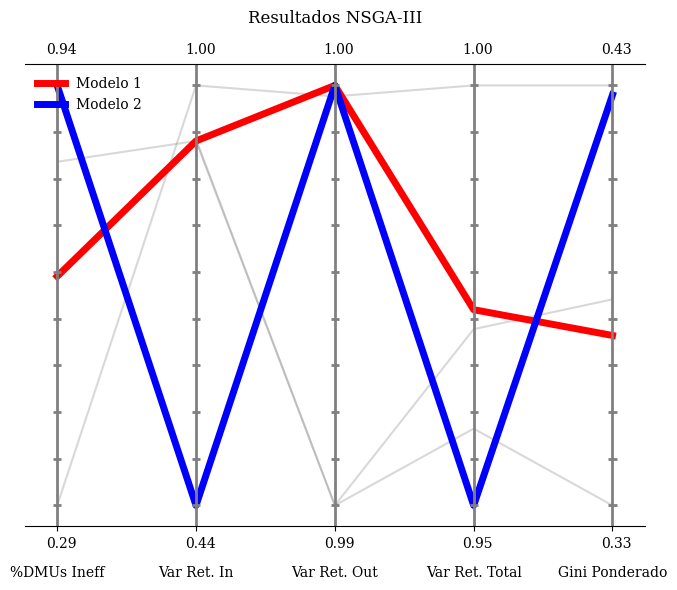

In [ ]:
# @title
# Definir los labels
labels = ["%DMUs Ineff", "Var Ret. In", "Var Ret. Out", "Var Ret. Total", "Gini Ponderado"]

# Número de dimensiones de res_nsga2.F
num_dim = len(labels)  # Asegúrate de que el número de labels coincida con las dimensiones de res_nsga2.F

# Selección de modelos a destacar (por ejemplo, Modelo 1 y Modelo 2)
#modelos_a_destacar = [0, 2]  # Índices de las filas a destacar en res_nsga2.F

# Genera el gráfico de coordenadas paralelas
plot = PCP(title=("Resultados NSGA-III", {'pad': 30}),
           n_ticks=10,
           legend=(True, {'loc': "upper left", 'frameon': False}),
           labels=labels)

plot.set_axis_style(color="grey", alpha=1)

# Añade todas las soluciones (con menor opacidad)
plot.add(np.abs(res_nsga3.F), color="grey", alpha=0.3)

# Colores para los modelos destacados
colores = ["red", "blue"]

# Graficar dinámicamente los modelos seleccionados
for i, modelo in enumerate(modelos_a_destacar):
    plot.add(np.abs(res_nsga3.F[modelo]),
             linewidth=5,
             color=colores[i % len(colores)],  # Asigna colores cíclicamente si hay más modelos
             label=f"Modelo {modelo + 1}")

plot.show()

## AGE-MOEA

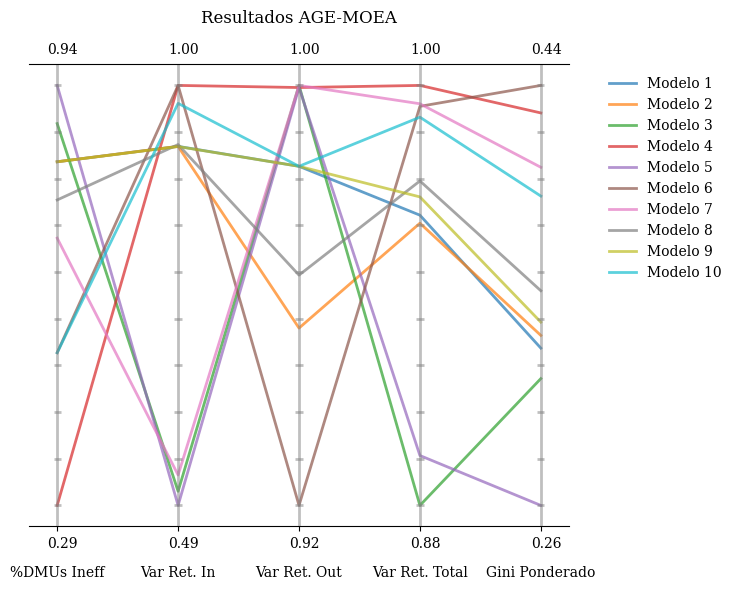

In [ ]:
# @title
import numpy as np
import matplotlib.pyplot as plt
from pymoo.visualization.pcp import PCP

# Definir los labels
labels = ["%DMUs Ineff", "Var Ret. In", "Var Ret. Out", "Var Ret. Total", "Gini Ponderado"]

# Número de dimensiones de res_nsga2.F
num_dim = len(labels)  # Asegúrate de que el número de labels coincida con las dimensiones de res_nsga2.F

# Genera el gráfico de coordenadas paralelas
plot = PCP(title=("Resultados AGE-MOEA", {'pad': 30}),
           n_ticks=10,
           legend=(True, {'loc': "upper left", 'frameon': False}),
           labels=labels)  # Usa los labels proporcionados

plot.set_axis_style(color="grey", alpha=0.5)

# Número de soluciones en res_nsga2.F
num_solutions = res_agemoea.F.shape[0]

# Genera un mapa de colores con Matplotlib
colors = plt.cm.tab10(np.linspace(0, 1, num_solutions))  # Usa un colormap con 10 colores distintos

# Añade las soluciones al gráfico con etiquetas "Modelo 1", "Modelo 2", ..., etc.
for i in range(num_solutions):
    label = f"Modelo {i + 1}"  # Etiquetas del tipo "Modelo 1", "Modelo 2", ...

    # Obtener el valor absoluto de res_nsga2.F[i]
    abs_solution = np.abs(res_agemoea.F[i])

    plot.add(abs_solution, linewidth=2, color=colors[i % 10], alpha=0.7, label=label)

# Muestra el gráfico
plot.show()

# Después de mostrar el gráfico, usamos matplotlib para mover la leyenda
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), frameon=False)
plt.subplots_adjust(right=0.8)  # Ajustar para evitar que se corte la leyenda
plt.show()

In [ ]:
# Selección de modelos a destacar (por ejemplo, Modelo 1 y Modelo 2)
modelos_a_destacar = [0, 3]  # Índices de las filas a destacar en res_nsga2.F

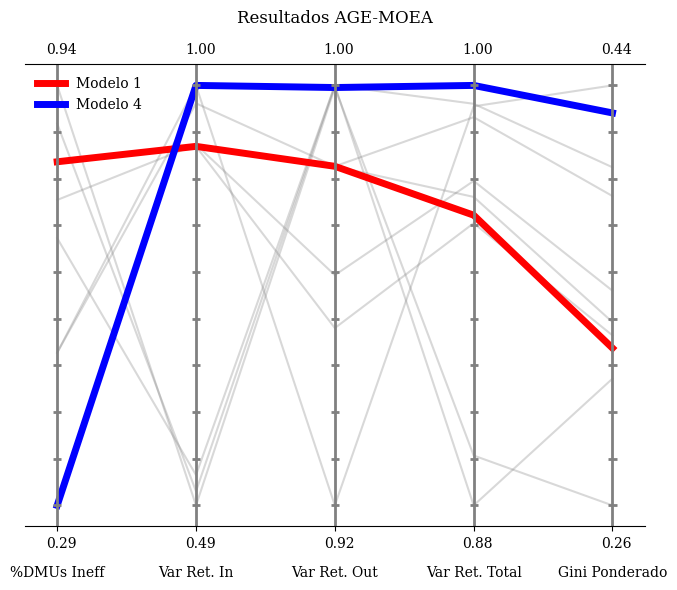

In [ ]:
# @title
# Definir los labels
labels = ["%DMUs Ineff", "Var Ret. In", "Var Ret. Out", "Var Ret. Total", "Gini Ponderado"]

# Número de dimensiones de res_nsga2.F
num_dim = len(labels)  # Asegúrate de que el número de labels coincida con las dimensiones de res_nsga2.F

# Selección de modelos a destacar (por ejemplo, Modelo 1 y Modelo 2)
#modelos_a_destacar = [0, 2]  # Índices de las filas a destacar en res_nsga2.F

# Genera el gráfico de coordenadas paralelas
plot = PCP(title=("Resultados AGE-MOEA", {'pad': 30}),
           n_ticks=10,
           legend=(True, {'loc': "upper left", 'frameon': False}),
           labels=labels)

plot.set_axis_style(color="grey", alpha=1)

# Añade todas las soluciones (con menor opacidad)
plot.add(np.abs(res_agemoea.F), color="grey", alpha=0.3)

# Colores para los modelos destacados
colores = ["red", "blue"]

# Graficar dinámicamente los modelos seleccionados
for i, modelo in enumerate(modelos_a_destacar):
    plot.add(np.abs(res_agemoea.F[modelo]),
             linewidth=5,
             color=colores[i % len(colores)],  # Asigna colores cíclicamente si hay más modelos
             label=f"Modelo {modelo + 1}")

plot.show()

## SMS-EMOA

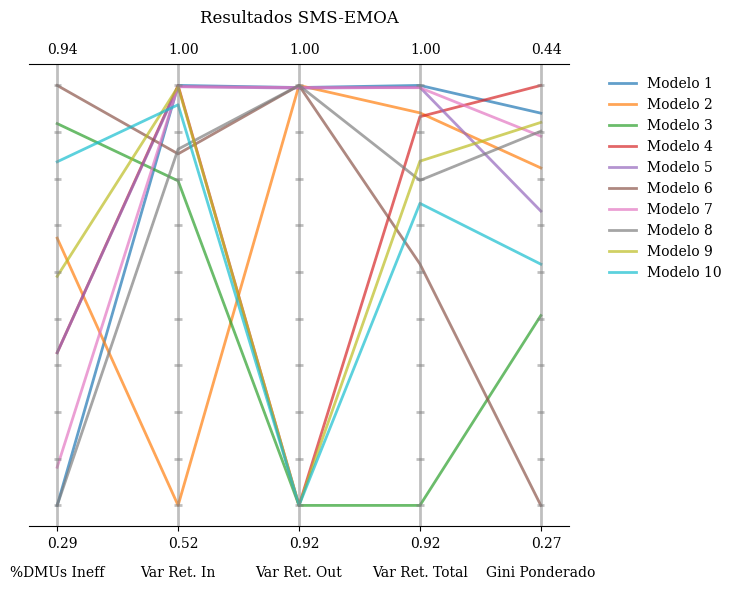

In [ ]:
# @title
import numpy as np
import matplotlib.pyplot as plt
from pymoo.visualization.pcp import PCP

# Definir los labels
labels = ["%DMUs Ineff", "Var Ret. In", "Var Ret. Out", "Var Ret. Total", "Gini Ponderado"]

# Número de dimensiones de res_nsga2.F
num_dim = len(labels)  # Asegúrate de que el número de labels coincida con las dimensiones de res_nsga2.F

# Genera el gráfico de coordenadas paralelas
plot = PCP(title=("Resultados SMS-EMOA", {'pad': 30}),
           n_ticks=10,
           legend=(True, {'loc': "upper left", 'frameon': False}),
           labels=labels)  # Usa los labels proporcionados

plot.set_axis_style(color="grey", alpha=0.5)

# Número de soluciones en res_nsga2.F
num_solutions = res_smsemoa.F.shape[0]

# Genera un mapa de colores con Matplotlib
colors = plt.cm.tab10(np.linspace(0, 1, num_solutions))  # Usa un colormap con 10 colores distintos

# Añade las soluciones al gráfico con etiquetas "Modelo 1", "Modelo 2", ..., etc.
for i in range(num_solutions):
    label = f"Modelo {i + 1}"  # Etiquetas del tipo "Modelo 1", "Modelo 2", ...

    # Obtener el valor absoluto de res_nsga2.F[i]
    abs_solution = np.abs(res_smsemoa.F[i])

    plot.add(abs_solution, linewidth=2, color=colors[i % 10], alpha=0.7, label=label)

# Muestra el gráfico
plot.show()

# Después de mostrar el gráfico, usamos matplotlib para mover la leyenda
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), frameon=False)
plt.subplots_adjust(right=0.8)  # Ajustar para evitar que se corte la leyenda
plt.show()

In [ ]:
# Selección de modelos a destacar (por ejemplo, Modelo 1 y Modelo 2)
modelos_a_destacar = [0, 1]  # Índices de las filas a destacar en res_nsga2.F

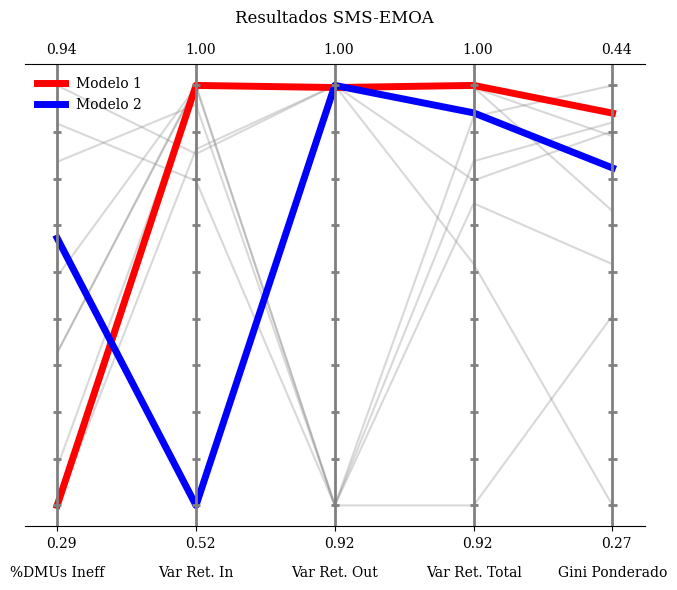

In [ ]:
# @title
# Definir los labels
labels = ["%DMUs Ineff", "Var Ret. In", "Var Ret. Out", "Var Ret. Total", "Gini Ponderado"]

# Número de dimensiones de res_nsga2.F
num_dim = len(labels)  # Asegúrate de que el número de labels coincida con las dimensiones de res_nsga2.F

# Selección de modelos a destacar (por ejemplo, Modelo 1 y Modelo 2)
#modelos_a_destacar = [0, 2]  # Índices de las filas a destacar en res_nsga2.F

# Genera el gráfico de coordenadas paralelas
plot = PCP(title=("Resultados SMS-EMOA", {'pad': 30}),
           n_ticks=10,
           legend=(True, {'loc': "upper left", 'frameon': False}),
           labels=labels)

plot.set_axis_style(color="grey", alpha=1)

# Añade todas las soluciones (con menor opacidad)
plot.add(np.abs(res_smsemoa.F), color="grey", alpha=0.3)

# Colores para los modelos destacados
colores = ["red", "blue"]

# Graficar dinámicamente los modelos seleccionados
for i, modelo in enumerate(modelos_a_destacar):
    plot.add(np.abs(res_smsemoa.F[modelo]),
             linewidth=5,
             color=colores[i % len(colores)],  # Asigna colores cíclicamente si hay más modelos
             label=f"Modelo {modelo + 1}")

plot.show()

## Gráfica Comportamiento Gini

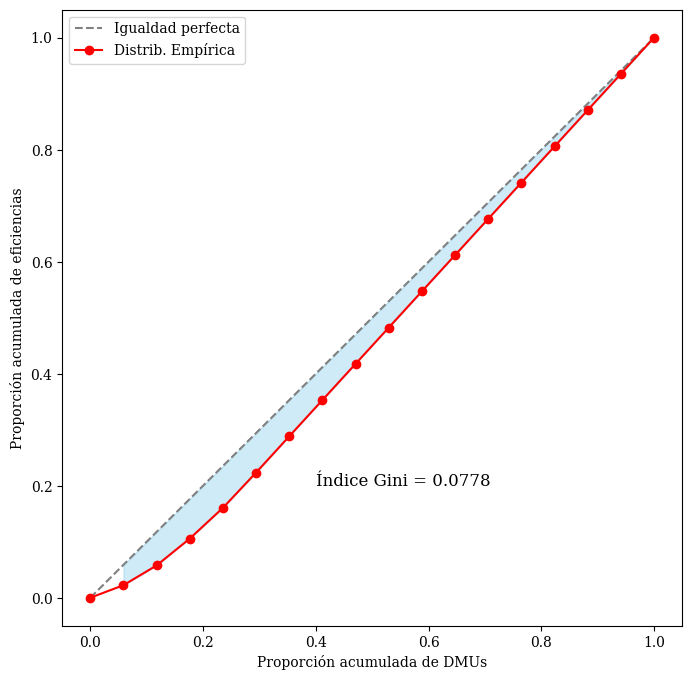

In [ ]:
# @title
import matplotlib.pyplot as plt
eff_dea = analyze_dea(Entradas, Salidas, tipo_modelo_dea)
def gini_index_graf(vector):
    """
    Calcula el índice de Gini para un vector dado.
    Si la suma del vector es cero, retorna 0.0.
    """
    vector = np.array(vector)
    total_sum = np.sum(vector)
    if total_sum == 0:
        return 0.0

    vector_sorted = np.sort(vector.flatten())
    cum_vector = np.cumsum(vector_sorted) / total_sum
    n = len(vector_sorted)
    cum_aux = (np.arange(1, n+1) / n)
    gini_s = (np.sum(cum_aux - cum_vector)) / np.sum(cum_aux)

    return round(gini_s, 4), cum_vector, cum_aux

def plot_lorenz_curve(vector):
    gini_value, cum_vector, cum_aux = gini_index_graf(vector)

    plt.figure(figsize=(8, 8))

    # Línea de igualdad perfecta (diagonal)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label="Igualdad perfecta")

    # Curva de Lorenz
    plt.plot(np.concatenate([[0], cum_aux]), np.concatenate([[0], cum_vector]), marker='o', color='red', label="Distrib. Empírica")

    # Agregar texto del índice de Gini
    plt.fill_between(cum_aux, cum_aux, cum_vector, color="skyblue", alpha=0.4)
    plt.text(0.4, 0.2, f"Índice Gini = {gini_value}", fontsize=12, color="black")

    # Etiquetas y leyenda
    plt.xlabel("Proporción acumulada de DMUs")
    plt.ylabel("Proporción acumulada de eficiencias")
    plt.legend()

    plt.show()

plot_lorenz_curve(eff_dea[0])

# **Guardar los Resultados**


In [ ]:
# @title
import pandas as pd
import numpy as np
from pymoo.indicators.hv import HV

# Parámetros para el modelo evaluado
parametros = {
    'Datos Utilizados': output_path,
    'Tipo de Modelo DEA': tipo_modelo_dea,
    'Tipo de Resultado': tipo_resultado,
    'N° Generaciones': generaciones,
    'N° Poblacion Inicial': poblacion,
    'N° Objetivos': n_obj,
}

# Convierte los parámetros en un DataFrame
df_parametros = pd.DataFrame(list(parametros.items()), columns=['Parámetro', 'Valor'])

# Diccionario que contiene los resultados
resultados = {
    'NSGA-II': resul_nsga2,
    'NSGA-III': resul_nsga3,
    'AGE-MOEA': resul_agemoea,
    'SMS-EMOA': resul_smsemoa
    #'KGB': resul_kgb,
    #'DNSGA2': resul_dnsga2,
    #'AGE-MOEA2': resul_agemoea2
}

# Diccionario para almacenar los hipervolúmenes
hv_resultados_dict = {}

# Diccionario de resultados y problemas asociados para el hipervolumen
resultados_hv = {
    "NSGA-II": (res_nsga2.X, res_nsga2.F, problem_nsga2),
    "NSGA-III": (res_nsga3.X, res_nsga3.F, problem_nsga3),
    "AGE-MOEA": (res_agemoea.X, res_agemoea.F, problem_agemoea),
    "SMS-EMOA": (res_smsemoa.X, res_smsemoa.F, problem_smsemoa)
    #"KGB": (res_kgb.X, res_kgb.F, problem_kgb),
    #"DNSGA2": (res_dnsga2.X, res_dnsga2.F, problem_dnsga2),
    #"AGE-MOEA2": (res_agemoea2.X, res_agemoea2.F, problem_agemoea2)
}

# Evaluar hipervolumen para cada algoritmo
for nombre, (X, F, problem) in resultados_hv.items():
    # Procesa los arrays positivos y negativos
    resul_pos = process_and_store_results_auto_(X, F, problem)
    resul_neg = process_and_store_results_auto_neg(X, F, problem)

    # Genera los arrays numéricos para los valores positivos y negativos
    num_arr_pos = resul_pos.select_dtypes(include=[np.number]).to_numpy()
    num_arr_neg = resul_neg.select_dtypes(include=[np.number]).to_numpy()

    # Ref point para los valores positivos
    ref_point_pos = np.full(num_arr_pos.shape[1], 1)

    # Calcular HV para positivos
    ind_pos = HV(ref_point=ref_point_pos)
    hv_pos = ind_pos(num_arr_pos)

    # Ref point para negativos y cálculo
    ref_point_neg = np.full(num_arr_neg.shape[1], 0)
    ind_neg = HV(ref_point=ref_point_neg)
    hv_neg = ind_neg(num_arr_neg)

    # Guardar los resultados de HV en el diccionario
    hv_resultados_dict[nombre] = {
        'HV Positivo': hv_pos,
        'HV Negativo': hv_neg
    }

# Crear un DataFrame para los resultados de HV
df_hv_resultados = pd.DataFrame(hv_resultados_dict).T

# Crear un DataFrame para guardar todos los resultados en una sola hoja
combined_results = []
for nombre, df_resultados in resultados.items():
    # Añadir el nombre como columna en los resultados
    df_resultados['Nombre'] = nombre  # Añadir columna con el nombre
    combined_results.append(df_resultados)
    # Añadir una fila vacía después de cada conjunto de resultados
    combined_results.append(pd.DataFrame(columns=df_resultados.columns))  # Fila vacía

# Filtrar las entradas vacías antes de concatenar
combined_results = [df for df in combined_results if not df.empty]

# Concatenar todos los DataFrames en uno solo
df_combined_results = pd.concat(combined_results, ignore_index=True)

# Guardar en un archivo Excel
nombre_archivo_final = 'resultados_combinados.xlsx'
with pd.ExcelWriter(nombre_archivo_final, engine='openpyxl') as writer:
    # Guardar los resultados combinados en una hoja
    df_combined_results.to_excel(writer, sheet_name='Resultados Combinados', index=False)
    # Guardar los parámetros en otra hoja
    df_parametros.to_excel(writer, sheet_name='Parámetros', index=False)
    # Guardar los hipervolúmenes en otra hoja
    df_hv_resultados.to_excel(writer, sheet_name='Hipervolumen', index=True)

print(f"{nombre_archivo_final} - guardado con éxito.")

# Descargar (si estás trabajando en Google Colab)
from google.colab import files
files.download(nombre_archivo_final)


resultados_combinados.xlsx - guardado con éxito.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>